# Final Project 
#### Group Members :- Aditya Kesari, Fiona Wang, Dhruv Rana

---

## 0. Import 

In [1]:
import cv2
import os
import time
import copy
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as Image_display

from skimage.io import imread

import torch
from torch.utils.data import Dataset, DataLoader, random_split

import tensorflow as tf

import torch.nn as nn
from torchvision import transforms, models
from torchsummary import summary
from keras.applications import vgg16
from sklearn.metrics import confusion_matrix

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


## 1. Label Colors

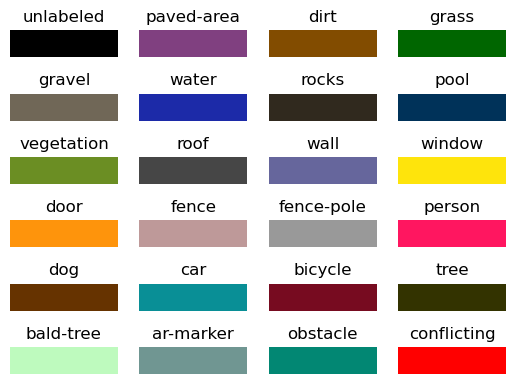

In [2]:
label_map = pd.read_csv("./archive/class_dict_seg.csv")

for index,label in enumerate(label_map["name"]):
    plt.subplot(6,4,index+1)
    (R,G,B) = label_map.iloc[index][1:]
    color = np.array([[[R,G,B],[R,G,B],[R,G,B],[R,G,B]]]) # need a MxNx4 array to use imshow to plot colors
    plt.imshow(color)
    plt.title(label)
    plt.axis("off")

plt.show()

num_classes = label_map["name"].size

## 2. Examine Data

In [3]:
image_dir = "./archive/dataset/semantic_drone_dataset/original_images/"
mask_dir = "./archive/RGB_color_image_masks/RGB_color_image_masks/"


image_path = np.array(sorted(glob.glob(image_dir+"*.jpg")))
mask_path = np.array(sorted(glob.glob(mask_dir+"*.png")))

print("Total Images in dataset: ", len(image_path))

Total Images in dataset:  400


In [4]:
id_num = 300

img = Image.open(image_path[id_num])
mask = Image.open(mask_path[id_num])

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

IMG_HEIGHT,IMG_WIDTH,IMG_CH = np.asarray(img).shape

Image Size (4000, 6000, 3)
Mask Size (4000, 6000, 3)


## 3. Examine Mask

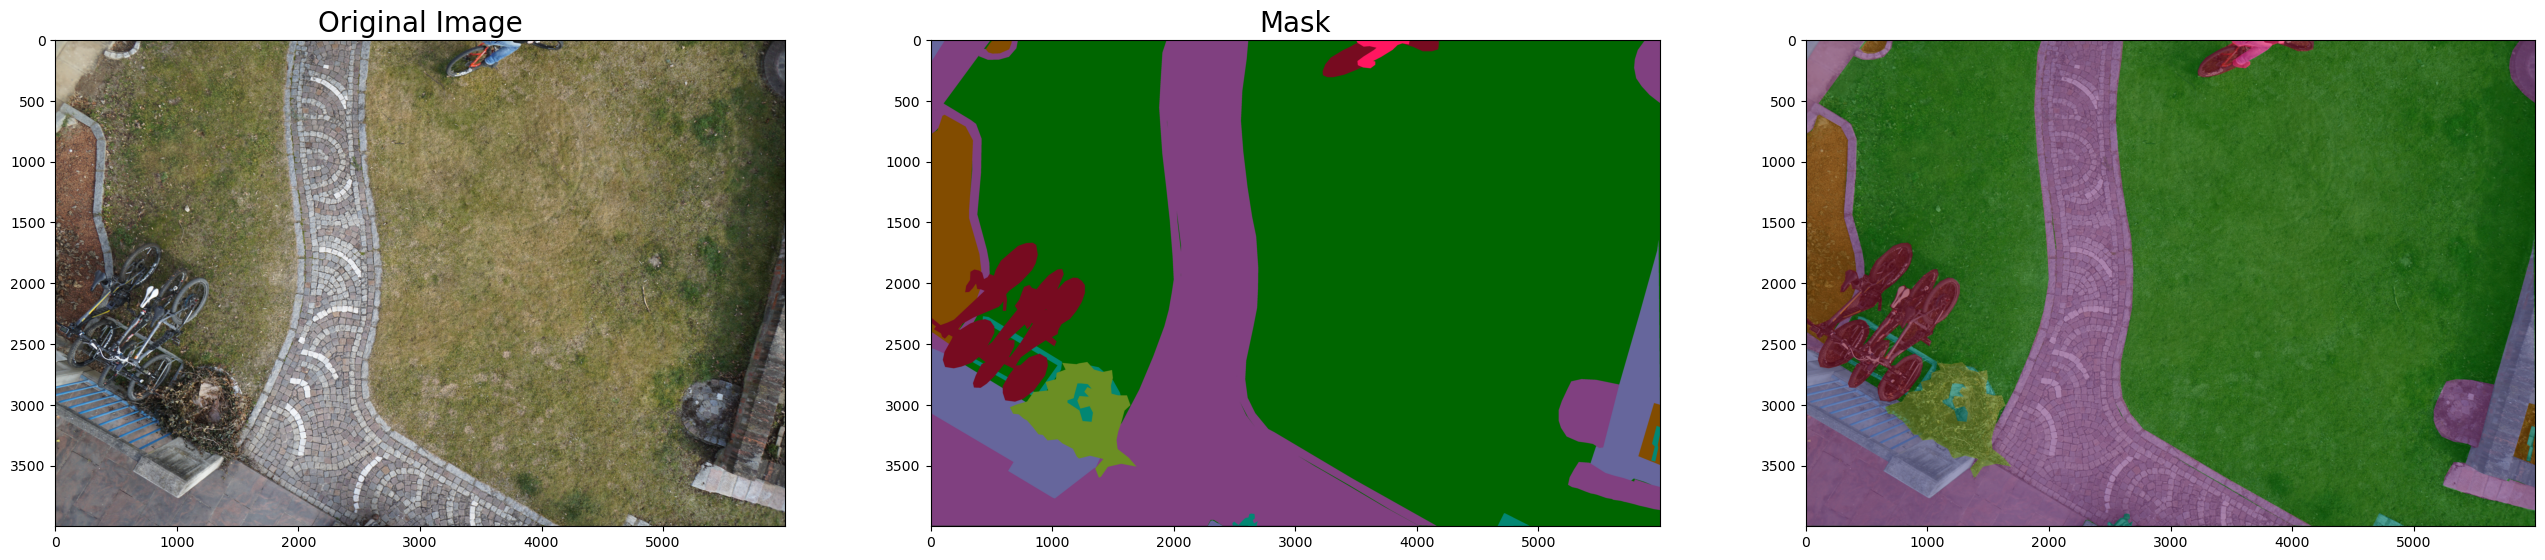

In [5]:
fig, axs = plt.subplots(1,3,figsize=(32,32))
axs[0].imshow(img)
axs[0].set_title("Original Image",size=20)

axs[1].imshow(mask)
axs[1].set_title("Mask",size=20)

axs[2].imshow(img)
axs[2].imshow(mask, alpha=0.6)
axs[2].set_title("Mask Applied",size=20)

plt.title("")
plt.show()

## Hyperparameters

In [6]:
# Percentage of how to split the dataset
TRAIN_SPLIT = 0.9 # 90%
TEST_SPLIT = 0.1  # 10%

# Amount of images in one batch
BATCH_SIZE = 3
# Randmoize Image order
SHUFFLE = True

#images are very large (4000x6000)
factor = 8
RESIZE_HEIGHT = int((2**5)*factor) # layer depth = 5 and conv reduces image by factor of 2
RESIZE_WIDTH = int((2**5)*factor*1.5)

# Training Parameters
EPOCHS = 40
LEARNING_RATE = 0.001

## 4.Split &  Load Data

#### i) Make Dataset

In [7]:
# Need to make a custom Dataset as no built function achives the functinaly of having image as a label
class SegmentationImageDataset(Dataset):
    def __init__ (self,img_path,mask_path,transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
    
    def __len__ (self):
        return len(self.img_path)

    def __getitem__(self, index:int):
        img_ID = image_path[index]
        mask_ID = mask_path[index]

        X,Y = imread(img_ID).astype(np.uint8), imread(mask_ID).astype(np.uint8)

        if self.transform is not None :
            X = self.transform(X)
        
        X,Y = torch.from_numpy(np.asarray(X)), torch.from_numpy(np.asarray(Y))

        return X,Y

In [8]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((RESIZE_HEIGHT, RESIZE_WIDTH),antialias=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225]), # normalize picture based on imagenet
])

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.ToPILImage()
])

dataset = SegmentationImageDataset(image_path,mask_path,transform=data_transform)
DATASET_SIZE = len(dataset)

#### ii) Split Data

In [9]:
train_data, test_data = random_split(dataset, [ int(TRAIN_SPLIT*DATASET_SIZE) , int(TEST_SPLIT*DATASET_SIZE)])

#### iii) Load Data

In [10]:
train_loader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

## 5. Display & Helper Functions 

In [11]:
def display_img_mask_applied(img,mask,prediction,title):
    fig, axs = plt.subplots(2,3,figsize=(30,10))
    axs[0][0].imshow(img)
    axs[0][0].set_title("Original Image",size=20)
    
    axs[0][1].imshow(mask)
    axs[0][1].set_title("Mask",size=20)

    axs[0][2].imshow(img)
    axs[0][2].imshow(mask, alpha=0.6)
    axs[0][2].set_title("Mask Applied",size=20)

    axs[1][0].imshow(img)
    axs[1][0].set_title("Original Image",size=20)

    axs[1][1].imshow(prediction)
    axs[1][1].set_title("Predicted Mask",size=20)

    axs[1][2].imshow(img)
    axs[1][2].imshow(prediction, alpha=0.6)
    axs[1][2].set_title("Predicted Mask Applied",size=20)

    fig.suptitle(title,fontsize=20)
    plt.show()


In [12]:

def resize_masks(mask:torch.Tensor):
    if(len(mask.size()) == 4):
        batch,height,width,ch = mask.size()
        resize_mask = np.zeros((batch,RESIZE_HEIGHT,RESIZE_WIDTH,ch))
        for batch_idx in range(batch):
            resize_mask[batch_idx] = cv2.resize(mask[batch_idx].numpy(),(RESIZE_WIDTH,RESIZE_HEIGHT),interpolation=cv2.INTER_LINEAR_EXACT)
        return torch.tensor(resize_mask.astype(int))
    
    if(len(mask.size()) == 3):
        height,width,ch = mask.size()
        resize_mask = cv2.resize(mask.to(torch.int32).numpy(),(RESIZE_WIDTH,RESIZE_HEIGHT),interpolation=cv2.INTER_LINEAR_EXACT)
        return torch.tensor(resize_mask)  

In [13]:

def class_decoded_RGB_mask(mask:torch.Tensor, label_df:pd.DataFrame):
    """" Mask is (Batch Size x height X width) where each pixel is class encoded number"""
    if(len(mask.size()) == 3):
        batch,height,width = mask.size()
        rgb_mask = np.zeros((batch,height,width,3))
        COLORS = label_df[[' r', ' g', ' b']].to_numpy().astype("int")
        rgb_mask = COLORS[mask.cpu().to(torch.int32).numpy()]
        rgb_mask = torch.tensor(np.transpose(rgb_mask,axes=(0,3,1,2)).astype(int))
        return rgb_mask
    
    if(len(mask.size()) == 2):
        height,width = mask.size()
        rgb_mask = np.zeros((height,width,3))
        COLORS = label_df[[' r', ' g', ' b']].to_numpy().astype("int")
        rgb_mask = COLORS[mask.to(torch.int32).numpy()]
        rgb_mask = torch.tensor(np.transpose(rgb_mask,axes=(2,0,1)).astype(int))
        return rgb_mask

def class_encoded_mask(mask:torch.Tensor, label_df:pd.DataFrame):
    """" Mask is (Batch Size x CH x height X width) where each pixel is RGB correspoding to a class"""
    if(len(mask.size()) == 4):
        batch,height,width,ch = mask.size()
        encoded_mask = np.zeros((batch,height,width))
        COLORS = np.asarray(label_df[[' r', ' g', ' b']].to_numpy().astype("int"))
        mask = mask.cpu().numpy() 
        
        for i,color in enumerate(COLORS):
            encoded_mask[(mask == color).all(axis=3)] = i

        encoded_mask = torch.tensor(encoded_mask)
        return encoded_mask
    
    if(len(mask.size()) == 3):
        height,width,ch = mask.size()
        encoded_mask = np.zeros((height,width))
        COLORS = np.asarray(label_df[[' r', ' g', ' b']].to_numpy().astype("int"))
        mask = mask.cpu().numpy() 
        
        for i,color in enumerate(COLORS):
            encoded_mask[(mask == color).all(axis=2)] = i

        encoded_mask = torch.tensor(encoded_mask)
        return encoded_mask      

In [14]:

def class_decoded_RGB_mask(mask:torch.Tensor, label_df:pd.DataFrame):
    """" Mask is (Batch Size x height X width) where each pixel is class encoded number"""
    if(len(mask.size()) == 3):
        batch,height,width = mask.size()
        rgb_mask = np.zeros((batch,height,width,3))
        COLORS = label_df[[' r', ' g', ' b']].to_numpy().astype("int")
        rgb_mask = COLORS[mask.cpu().to(torch.int32).numpy()]
        rgb_mask = torch.tensor(np.transpose(rgb_mask,axes=(0,3,1,2)).astype(int))
        return rgb_mask
    
    if(len(mask.size()) == 2):
        height,width = mask.size()
        rgb_mask = np.zeros((height,width,3))
        COLORS = label_df[[' r', ' g', ' b']].to_numpy().astype("int")
        rgb_mask = COLORS[mask.to(torch.int32).numpy()]
        rgb_mask = torch.tensor(np.transpose(rgb_mask,axes=(2,0,1)).astype(int))
        return rgb_mask


In [15]:

def class_encoded_mask(mask:torch.Tensor, label_df:pd.DataFrame):
    """" Mask is (Batch Size x CH x height X width) where each pixel is RGB correspoding to a class"""
    if(len(mask.size()) == 4):
        batch,height,width,ch = mask.size()
        encoded_mask = np.zeros((batch,height,width))
        COLORS = np.asarray(label_df[[' r', ' g', ' b']].to_numpy().astype("int"))
        mask = mask.cpu().numpy() 
        
        for i,color in enumerate(COLORS):
            encoded_mask[(mask == color).all(axis=3)] = i

        encoded_mask = torch.tensor(encoded_mask)
        return encoded_mask
    
    if(len(mask.size()) == 3):
        height,width,ch = mask.size()
        encoded_mask = np.zeros((height,width))
        COLORS = np.asarray(label_df[[' r', ' g', ' b']].to_numpy().astype("int"))
        mask = mask.cpu().numpy() 
        
        for i,color in enumerate(COLORS):
            encoded_mask[(mask == color).all(axis=2)] = i

        encoded_mask = torch.tensor(encoded_mask)
        return encoded_mask      

## 6. Performance Metrics

In [16]:
def compute_performance(model:nn.Module,data_loader:DataLoader,device):
    torch.cuda.empty_cache()
    model.to(DEVICE)
    model = model.eval()

    all_masks = torch.empty(0)
    all_prediction = torch.empty(0)
            
    for batch_idx, (images, masks) in enumerate(train_loader): 
        all_masks = torch.cat([all_masks,resize_masks(masks)])   

        with torch.no_grad():     
            output = model(images.to(DEVICE))
            all_prediction = torch.cat([all_prediction,torch.argmax(output,dim=1).cpu()])
            torch.cuda.empty_cache()
        
    y_true = class_encoded_mask(all_masks.cpu(),label_map)
    y_true_flatten = y_true.flatten()
    y_pred_flatten = all_prediction.flatten()

    cf_matrix = confusion_matrix(y_true_flatten,y_pred_flatten,labels=range(num_classes))

    TP = np.array([cf_matrix[i][i] for i in range(len(cf_matrix[0]))])

    N = np.array([sum(cf_matrix[:,i]) for i in range(len(cf_matrix[0]))])
    FP = np.subtract(N,TP)

    P = np.array([sum(cf_matrix[i,:]) for i in range(len(cf_matrix[0]))])
    FN = np.subtract(P,TP)

    TN = np.subtract(np.array([sum(sum(cf_matrix)) for i in range(len(cf_matrix[0]))]) , np.subtract(TP,np.subtract(FP,FN)))

    precision = TP / (FP+TP)
    recall = TP / (FN+TP)
    f_score = 2 * (precision*recall)/(precision+recall)
    accuracy = TP / P
    IoU_score = (precision * recall) / (precision + recall - (precision * recall))

    return[accuracy,precision,recall,f_score,IoU_score]

## 7. Models

### Transfer Learning on Pre-Built Model  

#### i) Examine Model

In [17]:
torch.cuda.empty_cache()
# We first looked at all models provided by keras, and found the perfect balance in VGG
# VGG perfomrs really well and is not that dense, allowing us to easily modify and understand the new model.
input_shape = (IMG_CH,RESIZE_HEIGHT,RESIZE_WIDTH)

VGG16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(DEVICE)
VGG16 = VGG16.features
print(VGG16)

# Using Kera as it has better summary display
print("\nTabular Format :-")
vgg16.VGG16(include_top=False,input_shape=(RESIZE_HEIGHT,RESIZE_WIDTH,IMG_CH)).summary()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

#### ii) Decoder Block

In [18]:
# Up till now we have the encoder part of our model, but we need a decoder that takes us back to the input shape
def conv_block (in_channel,out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel,out_channel,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
    )

def decoder_block(in_channel,out_channel):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel,out_channel,kernel_size=2,stride=2),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
    )

#### iv) Build Model

In [19]:
class VGG_Unet(nn.Module):
    def __init__(self,out_channels):
        super().__init__()
        
        """" Encoder """
        encoder = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        self.block1 = nn.Sequential(encoder[0:4]) #64
        self.block2 = nn.Sequential(encoder[4:9]) #128
        self.block3 = nn.Sequential(encoder[9:16]) #256
        self.block4 = nn.Sequential(encoder[16:23]) #512
        self.block5 = nn.Sequential(encoder[23:30]) #512

        """ Bridge """
        self.vgg_last_layer = nn.Sequential(encoder[30:]) # last layer max pool

        self.bridge = conv_block(512,1024) # bridge

        """ Decoder """
        self.up_cov6 = decoder_block(1024,512) #512
        self.cov6_1 = conv_block(512+512,512) # conv the skip connect with block5
        self.cov6_2 = conv_block(512,512)

        self.up_cov7 = decoder_block(512, 512) #512
        self.cov7_1 = conv_block(512+512,512) # conv the skip connect with block4
        self.cov7_2 = conv_block(512,512)

        self.up_cov8 = decoder_block(512, 256) #256
        self.cov8_1 = conv_block(256+256,256) # conv the skip connect with block3
        self.cov8_2 = conv_block(256,256)

        self.up_cov9 = decoder_block(256, 128) #128
        self.cov9_1 = conv_block(128+128,128) # conv the skip connect with block2
        self.cov9_2 = conv_block(128,128)

        self.up_cov10 = decoder_block(128, 64) #64
        self.cov10_1 = conv_block(64+64,64) # conv the skip connect with block1
        self.cov10_2 = conv_block(64,64)

        self.conv11 = nn.Conv2d(64,out_channels=out_channels,kernel_size=1)




    def forward(self,x):
        """ Encoder """
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        """  Bridge"""

        x = self.vgg_last_layer(block5)
        x = self.bridge(x)

        """ Decoder """
        x = self.up_cov6(x)
        x = torch.cat([x,block5],dim=1) # Skip Connect
        x = self.cov6_1(x)
        x = self.cov6_2(x)

        x = self.up_cov7(x)
        x = torch.cat([x,block4],dim=1) # Skip Connect
        x = self.cov7_1(x)
        x = self.cov7_2(x)

        x = self.up_cov8(x)
        x = torch.cat([x,block3],dim=1) # Skip Connect
        x = self.cov8_1(x)
        x = self.cov8_2(x)

        x = self.up_cov9(x)
        x = torch.cat([x,block2],dim=1) # Skip Connect
        x = self.cov9_1(x)
        x = self.cov9_2(x)

        x = self.up_cov10(x)
        x = torch.cat([x,block1],dim=1) # Skip Connect
        x = self.cov10_1(x)
        x = self.cov10_2(x)

        x = self.conv11(x)

        return x

model = VGG_Unet(out_channels=num_classes).to(DEVICE)

#### v) Visulaize model

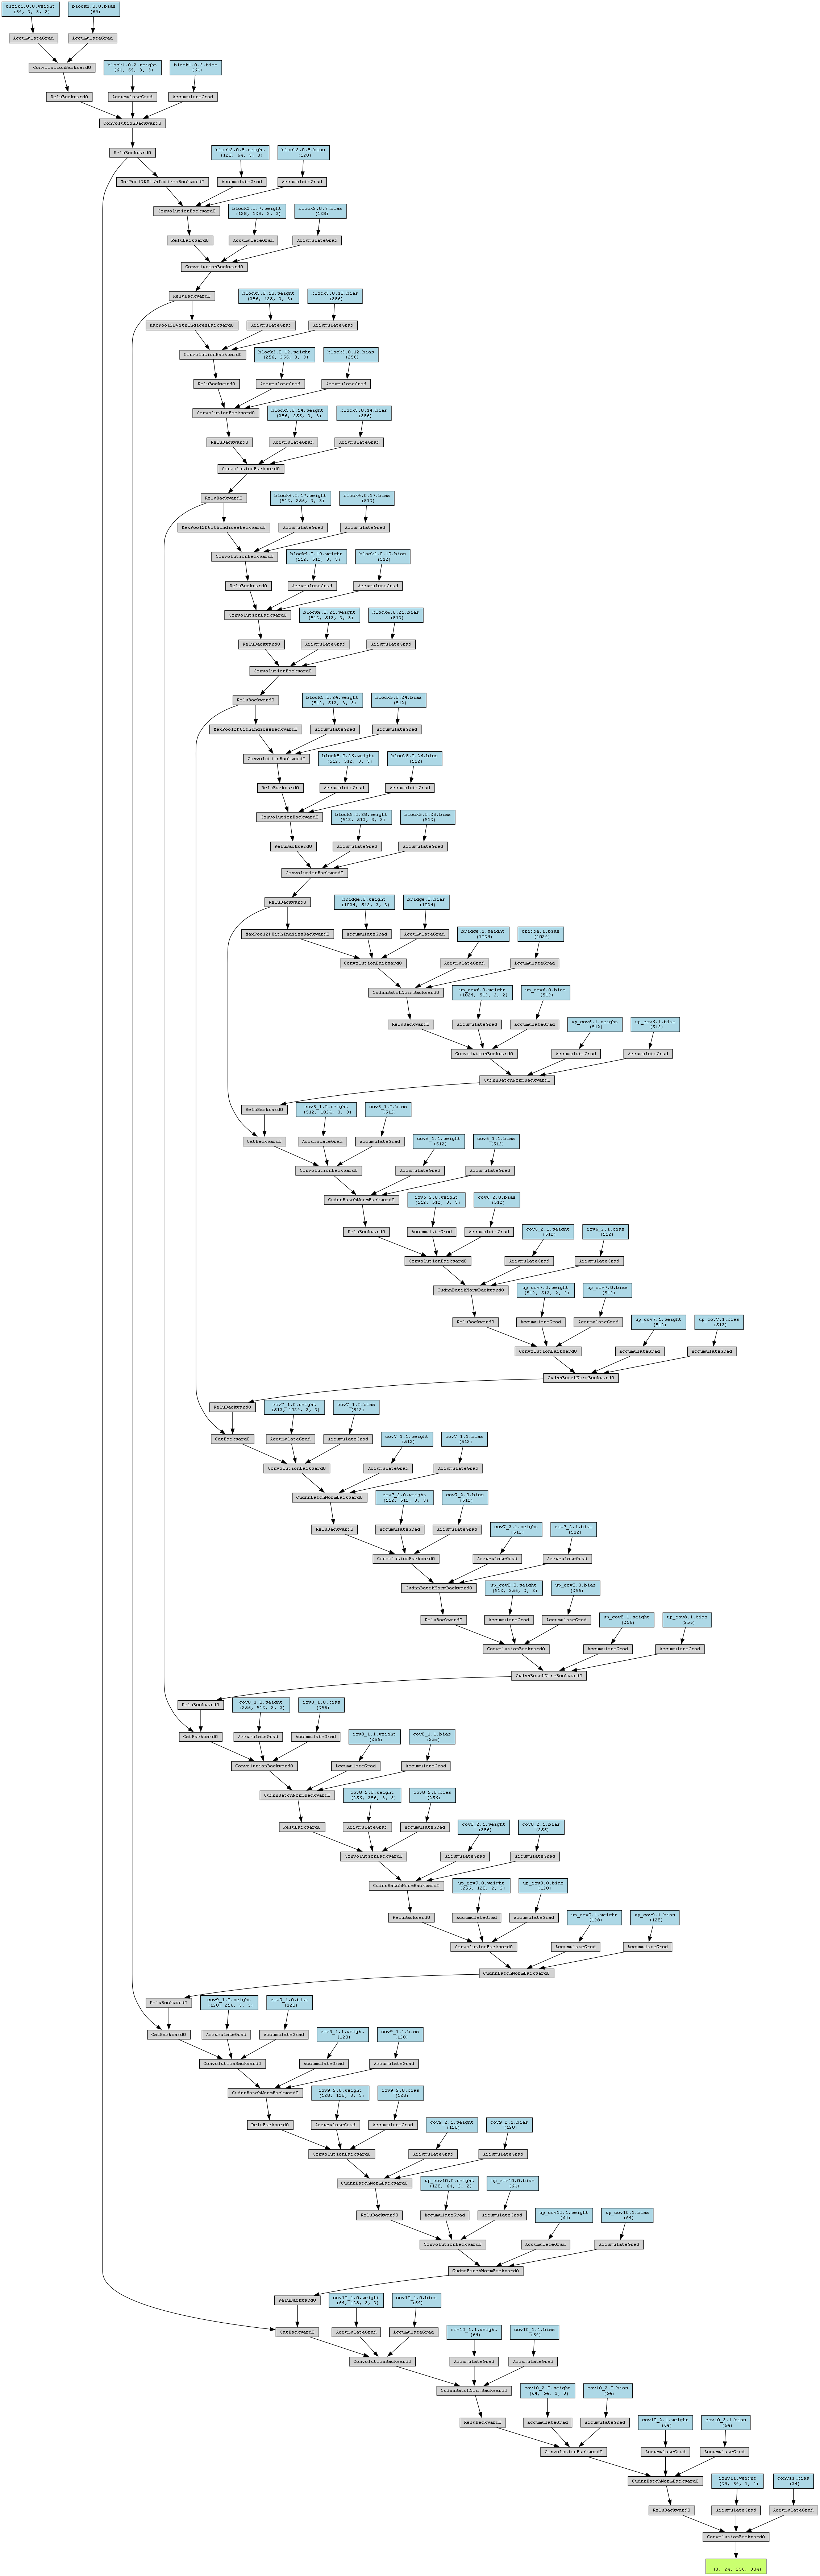

In [20]:
dataiter = iter(train_loader)
images, mask = next(dataiter)
yhat = model(images.to(DEVICE))

from torchviz import make_dot
make_dot(yhat, params=dict(list(model.named_parameters()))).render("model_torchviz", format="png")

Image_display(retina=True, filename='model_torchviz.png')

#### vi) Test Model w/o Training

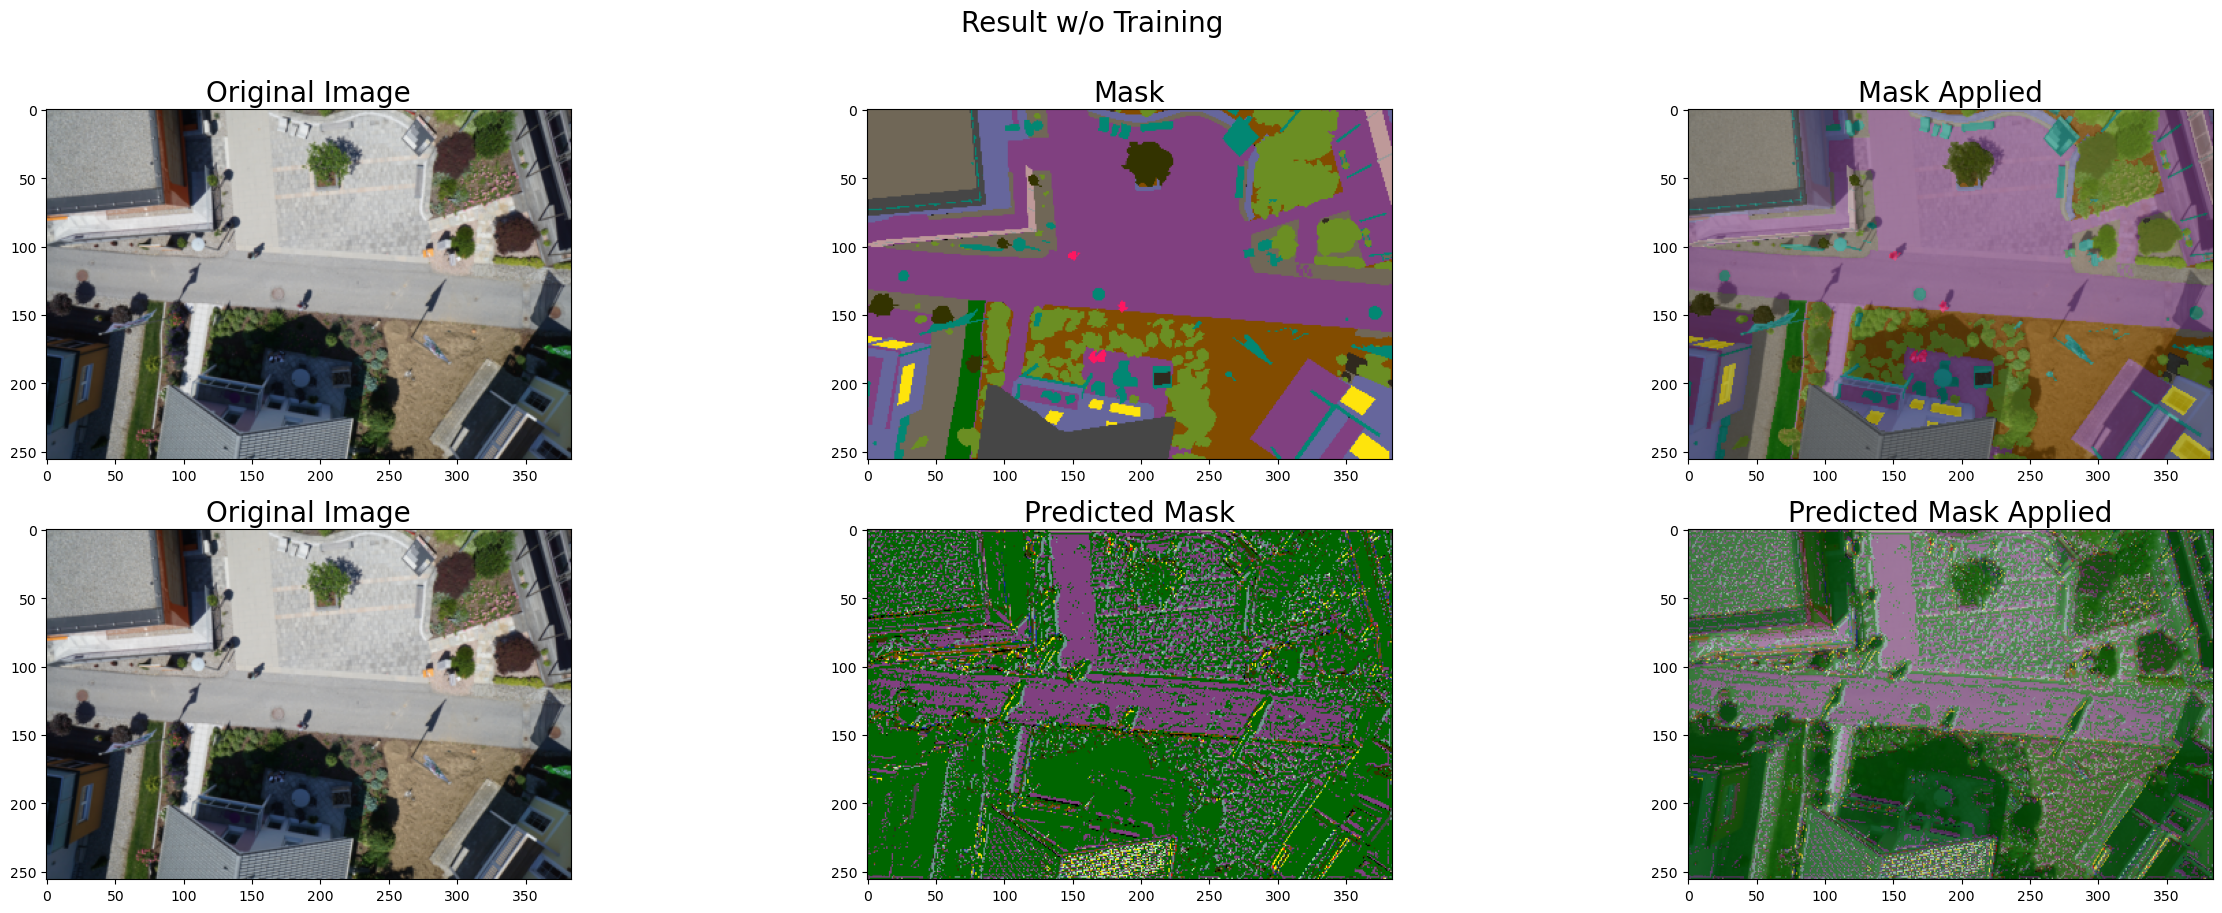

In [21]:
model = model.eval()

images, masks = next(iter(test_loader))

with torch.no_grad():
    output = model(images.to(DEVICE))
    prediction = torch.argmax(output,dim=1)
    rgb_mask = class_decoded_RGB_mask(prediction,label_map).cpu()

masks = resize_masks(masks)
img = inv_transform(torch.squeeze(images[0])) 
mask = torch.squeeze(masks[0])
predicted_mask = torch.squeeze(rgb_mask[0]).permute(1, 2, 0)

display_img_mask_applied(img,mask,predicted_mask,"Result w/o Training")

_We see that due to VGG we can already start extracting features from the images, without any training. Now we only need, to color code the learned features using the decoder blocks_

#### vii) Train Model

In [22]:
def train_model (model:nn.Module, data_loader:DataLoader, learning_rate, num_epochs, device):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    start_time = time.time()
    
    for epochs in range(num_epochs):
        
        print("EPOCH : {0}/{1}".format(epochs+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (images, masks) in enumerate(data_loader):
             
            output = model(images.to(DEVICE))
            prediction_mask = torch.argmax(output,dim=1)
            rgb_mask = class_decoded_RGB_mask(prediction_mask,label_map).cpu()
            
            optimizer.zero_grad()
            
            loss = nn.functional.cross_entropy(output.cpu(),class_encoded_mask(resize_masks(masks),label_map).type(torch.LongTensor))
            #loss.requires_grad = True
            
            loss.backward()
            optimizer.step()
            
            if (batch_index % 50 == 0) :
                print("BATCH : {:3d}/{:3d} | LOSS : {:.3f} ".format(batch_index,len(data_loader),loss))
            
        
        # evalute
        model.eval()
        with torch.set_grad_enabled(False):
            accuracy,_,_,_,_ = compute_performance(model,data_loader,DEVICE)
            print("\nTotal Accuracy On Training Data : {:.3f}%".format(accuracy))
        
        # Save best weights
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
        
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    
    model.load_state_dict(best_weights)
    return model

In [23]:
model = train_model(model,train_loader,LEARNING_RATE,EPOCHS,DEVICE)

EPOCH : 1/40
------------------------------
BATCH :   0/120 | LOSS : 3.165 
BATCH :  50/120 | LOSS : 1.788 


#### viii) Test Model w/ Training

In [ ]:
model = model.eval()

images, masks = next(iter(test_loader))

with torch.no_grad():
    output = model(images.to(DEVICE))
    prediction = torch.argmax(output,dim=1)
    rgb_mask = class_decoded_RGB_mask(prediction,label_map).cpu()

masks = resize_masks(masks)
img = inv_transform(torch.squeeze(images[0])) 
mask = torch.squeeze(masks[0])
predicted_mask = torch.squeeze(rgb_mask[0]).permute(1, 2, 0)

display_img_mask_applied(img,mask,predicted_mask,"Result w/ Training")

## 8. Performace Of Model